# Establishing a restaurant in an district of Madrid City

## Introduction 

The need arises to open a restaurant in Madrid capital, so it is necessary to know where to guide ourselves to assign the business by analyzing the market and the prices for each district. 
The problem that we have is that we are not clear about where to open the business and we want to be better informed of the activities in the districts, such as bars, shops, coffee shops, other restaurants for the competition, etc.

1. How many venues in each district?
2. How many categories in each district?
3. How many venues in each category?
4. What are the most popular categories in each district?
5. How many clusters we can use to categorize the districts based on the popularity of restaurants?
6. Choose the place we consider and view it on the map

## Data sources

1. [List of Madrid City districts](https://en.wikipedia.org/wiki/Madrid) from Wikipedia
2. [List of housing prices of Madrid city by district](https://www.madrid.es/UnidadesDescentralizadas/UDCEstadistica/Nuevaweb/Edificaci%C3%B3n%20y%20Vivienda/Mercado%20de%20la%20Vivienda/Precios%20de%20la%20Vivienda/Distritos/E3320121.xls) from Madrid City Council website 

## Methodology 

1. Extract the information by scraping table of Madrid city from wikipedia webpage and the average price for each housing district. This provides us with relevant information on the quality of life in each district. I will use the BeautifulSoup library to extract the information as it is very useful.
2. The Density column is calculated to see the number of people in each district based on the extracted columns Population (1 Jan 2020) and Area (ha).
3. The Nominatim functionality provided by the geopy.geocoders library is used to obtain the coordinates of each district and manipulate the information to assign it in a dataframe with Pandas.
4. I will use the Foursquare API to explore the venues in each district.
5. I will use the Folium library represent each restaurant in their respective locations and also the districts.
6. Matplotlib library will also be used to display the charts.

## Data Analysis

### Import all packages


In [1]:
import os
import pandas as pd
import numpy as np

# Convert an address into latitude and longitude values
from geopy.geocoders import Nominatim

# Tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize  

# Scrape the web to get the data
from bs4 import BeautifulSoup
import requests

!pip install folium
import folium # map rendering library
from folium import plugins

# Import k-means from clustering stage
from sklearn.cluster import KMeans

# Find the distances
from scipy.spatial.distance import cdist

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

print('Folium installed')
print('Libraries imported.')

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 94 kB 6.5 MB/s  eta 0:00:01
Folium installed
Libraries imported.


### Scrapping data

#### 1. Scrape the list of all 20 district on a wikipedia webpage of Madrid City.

In [6]:
source_wiki_hcm = requests.get("https://en.wikipedia.org/wiki/Madrid").text
soup = BeautifulSoup(source_wiki_hcm, 'lxml')
table_wiki_hcm = (soup.find(lambda tag:tag.name=="tr" and "District" in tag.text).parent.parent)
table_rows = table_wiki_hcm.tbody.find_all("tr")

districts_madrid = []
for tr in table_rows:
    td = tr.find_all("td")
    row = [tr.text for tr in td]
    districts_madrid.append(row)

# Remove first element and last element of list of districts
districts_madrid.pop(0)
del districts_madrid[-1]


In [7]:
df_madrid = pd.DataFrame(districts_madrid, columns=["District", "Population (1 Jan 2020)", "Area (ha)"])
df_madrid["Area (ha)"] = (df_madrid["Area (ha)"].str.replace("\n", ""))
df_madrid["Population (1 Jan 2020) aux"] = (df_madrid["Population (1 Jan 2020)"].str.replace(",", "")
                                .str.replace(".", "")
                                .str.strip())
df_madrid["Area (ha) aux"] = (df_madrid["Area (ha)"].str.replace("\n", "")
                                .str.replace(",", "")
                                .str.replace(".", "")
                                .str.strip())

# Add the "Density" column = Population / Area
df_madrid["Density (pop/m2)"] = round(df_madrid["Population (1 Jan 2020) aux"].astype(float) / df_madrid["Area (ha) aux"].astype(float), 3)
del df_madrid["Population (1 Jan 2020) aux"]
del df_madrid["Area (ha) aux"]
df_madrid = df_madrid.reset_index().drop("index", axis=1)

df_madrid

,District,Population (1 Jan 2020),Area (ha),Density (pop/m2)
0,Centro,"140,991",522.82,2.697
1,Arganzuela,"156,176",646.22,2.417
2,Retiro,"120,873",546.62,2.211
3,Salamanca,"148,405",539.24,2.752
4,Chamartín,"148,039",917.55,1.613
5,Tetuán,"161,991",537.47,3.014
6,Chamberí,"141,397",467.92,3.022
7,Fuencarral-El Pardo,"250,636","23,783.84",0.105
8,Moncloa-Aravaca,"122,164","4,653.11",0.263
9,Latina,"242,923","2,542.72",0.955


#### 2. Housing price

Collect the housing price at different districts of Madrid.

In [8]:
def excel_to_pandas(URL, local_path):
    resp = requests.get(URL)
    with open(local_path, 'wb') as output:
        output.write(resp.content)
    df = pd.read_excel(local_path)
    return df

# Get info housing prices
cwd = os.getcwd()
local_url = f'{cwd}/prices_houses_by_district_madrid.xlsx'
url = 'https://www.madrid.es/UnidadesDescentralizadas/UDCEstadistica/Nuevaweb/Edificaci%C3%B3n%20y%20Vivienda/Mercado%20de%20la%20Vivienda/Precios%20de%20la%20Vivienda/Distritos/E3320121.xls'
df_price_houses_madrid = excel_to_pandas(url, local_url)

# Clear columns
df_price_houses_madrid.rename(columns={'Unnamed: 1': 'District', 'Unnamed: 2': 'Average Housing Price (€/m2)'}, inplace=True)
df_price_houses_madrid.drop(df_price_houses_madrid.columns[0:1], axis=1, inplace=True)
df_price_houses_madrid.drop(df_price_houses_madrid.columns[2:20], axis=1, inplace=True)
df_price_houses_madrid = df_price_houses_madrid.dropna()
df_price_houses_madrid = df_price_houses_madrid.iloc[2:]
df_price_houses_madrid['District'] = df_price_houses_madrid['District'].str.replace('[\d.]','')
df_price_houses_madrid = df_price_houses_madrid.reset_index().drop("index", axis=1)
df_price_houses_madrid


,District,Average Housing Price (€/m2)
0,Centro,4802
1,Arganzuela,4000
2,Retiro,4692
3,Salamanca,5949
4,Chamartín,5115
5,Tetuán,3637
6,Chamberí,5248
7,Fuencarral-El Pardo,3518
8,Moncloa-Aravaca,4004
9,Latina,2265


#### 3. Get the coordinates of the districts

Find all coordinates of all urban districts in Madrid. Create a function to find the coordinates of a certain place.

In [9]:
def find_coordinate(name):
    address = name + " Madrid"
    geolocator = Nominatim(user_agent="madrid")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return [latitude, longitude]

Note: We cannot find the coordinate of "Distrito Centro Madrid" but "Centro Madrid". 
However, we need the word "Distito" to find the coordinate of districts whose name contains a number like "Distrito centro".

In [10]:
# For 1 to 20 districts 
coordinates = [find_coordinate("Distrito " + dist) for dist in df_madrid["District"].iloc[:20].tolist()]
coordinates = coordinates + [find_coordinate(dist + " Distrito") for dist in df_madrid["District"].iloc[20:].tolist()]

df_coordinates = pd.DataFrame(coordinates, columns=["Latitude", "Longitude"])

df_madrid["Latitude"] = df_coordinates["Latitude"]
df_madrid["Longitude"] = df_coordinates["Longitude"]

df_madrid

,District,Population (1 Jan 2020),Area (ha),Density (pop/m2),Latitude,Longitude
0,Centro,"140,991",522.82,2.697,43.542658,-5.664080
1,Arganzuela,"156,176",646.22,2.417,40.392827,-3.699313
2,Retiro,"120,873",546.62,2.211,40.402374,-3.677427
3,Salamanca,"148,405",539.24,2.752,40.427325,-3.683587
4,Chamartín,"148,039",917.55,1.613,40.476631,-3.675252
5,Tetuán,"161,991",537.47,3.014,40.460171,-3.700422
6,Chamberí,"141,397",467.92,3.022,40.433140,-3.697201
7,Fuencarral-El Pardo,"250,636","23,783.84",0.105,40.514767,-3.663639
8,Moncloa-Aravaca,"122,164","4,653.11",0.263,40.435119,-3.718717
9,Latina,"242,923","2,542.72",0.955,40.385128,-3.764642


### Plot the maps

#### 1. Define Foursquare Credentials and Version


In [11]:
CLIENT_ID = 'JM34QREU1GK5VI2NJYSJ5RJBR2YO1KLCLYPVEACLJ12NW1ON'
CLIENT_SECRET = 'YLBLSHQAF14LY04KVFZ4NSKYGTQ301RATD0H44SGLOPUBAM3'
VERSION = '20180323'
LIMIT = 40
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JM34QREU1GK5VI2NJYSJ5RJBR2YO1KLCLYPVEACLJ12NW1ON
CLIENT_SECRET:YLBLSHQAF14LY04KVFZ4NSKYGTQ301RATD0H44SGLOPUBAM3


#### 2. Make get requests near Madrid city.

In [13]:
request_parameters = {
    "client_id": CLIENT_ID,
    "client_secret": CLIENT_SECRET,
    "v": '20180605',
    "section": "restaurant",
    "near": "Madrid",
    "radius": 1000,
    "limit": 50}

data = requests.get("https://api.foursquare.com/v2/venues/explore", params=request_parameters)

#### 3. Get geolocation of Madrid City

In [14]:
response = data.json()["response"]
response["geocode"]

{'what': '',
 'where': 'madrid',
 'center': {'lat': 40.4165, 'lng': -3.70256},
 'displayString': 'Madrid, Spain',
 'cc': 'ES',
 'geometry': {'bounds': {'ne': {'lat': 40.64339099993895,
    'lng': -3.5178330153857993},
   'sw': {'lat': 40.273124093367976, 'lng': -3.8890639517477053}}},
 'slug': 'madrid',
 'longId': '72057594041045671'}

#### 4. Get coordinates center Madrid

In [15]:
madrid_center = response["geocode"]["center"]
latitude = madrid_center["lat"]
longitude = madrid_center["lng"]
madrid_center

{'lat': 40.4165, 'lng': -3.70256}

#### 5. Explore the venues of urbant districts

Create a function to find the nearby venues the indicated coordinates of each district of Madrid.

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500, LIMIT=150):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):           
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
df_nearby_restaurants = getNearbyVenues(names=df_madrid['District'],
                             latitudes=df_madrid['Latitude'],
                             longitudes=df_madrid['Longitude']
                            )
df_nearby_restaurants.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Centro,43.542658,-5.66408,Varsovia,43.543480,-5.661315,Nightclub
1,Centro,43.542658,-5.66408,Plaza Mayor,43.545013,-5.662647,Plaza
2,Centro,43.542658,-5.66408,Gloria,43.542354,-5.663559,Restaurant
3,Centro,43.542658,-5.66408,Ocean bar,43.543720,-5.666842,Cocktail Bar
4,Centro,43.542658,-5.66408,Librería Paradiso,43.542098,-5.662050,Bookstore


In [18]:
madrid_venues_group = df_nearby_restaurants.groupby('District').count().reset_index()
madrid_venues_group

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arganzuela,100,100,100,100,100,100
1,Barajas,67,67,67,67,67,67
2,Carabanchel,56,56,56,56,56,56
3,Centro,100,100,100,100,100,100
4,Chamartín,100,100,100,100,100,100
5,Chamberí,100,100,100,100,100,100
6,Ciudad Lineal,100,100,100,100,100,100
7,Fuencarral-El Pardo,100,100,100,100,100,100
8,Hortaleza,94,94,94,94,94,94
9,Latina,78,78,78,78,78,78


### Analysis of restaurants by district

#### 1. The list of unique categories

Limit the list of first 50 categories.

In [19]:
df_nearby_restaurants['Venue Category'].unique()[:50]

array(['Nightclub', 'Plaza', 'Restaurant', 'Cocktail Bar', 'Bookstore',
       'Winery', 'Brewery', 'Beer Store', 'Mexican Restaurant',
       'Juice Bar', 'Hotel', 'Pizza Place', 'Theater',
       'Spanish Restaurant', 'Wine Shop', 'Tapas Restaurant',
       'Scenic Lookout', 'Gift Shop', 'Sculpture Garden', 'Rock Club',
       'Paella Restaurant', 'Internet Cafe', 'Jazz Club', 'Beach',
       'Seafood Restaurant', 'Wine Bar', 'Japanese Restaurant',
       'Beer Garden', 'Spa', 'Pastry Shop', 'Steakhouse', 'Trail',
       'Italian Restaurant', 'Beer Bar', 'Museum', 'Bar',
       'Ice Cream Shop', 'Aquarium', 'Gastropub', 'Burger Joint',
       'Supermarket', 'Clothing Store', 'Greek Restaurant', 'Tea Room',
       'Snack Place', 'Lounge', 'BBQ Joint', 'Diner', 'Art Gallery',
       'Park'], dtype=object)

#### 2. Number of venues in each district

Plot a chart in order to compare visually the different of number of venues between districts.

Text(0, 0.5, 'Number of venues')

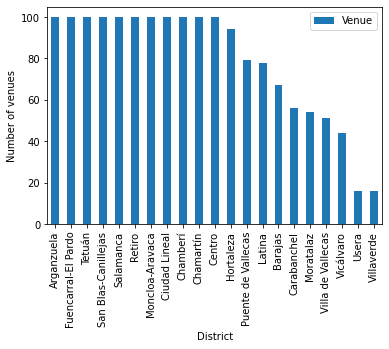

In [20]:
ax = madrid_venues_group.sort_values(by="Venue", ascending=False).plot(x="District", y="Venue", kind="bar")
ax.set_ylabel("Number of venues")

#### 3. The number of venues in each category.

In [21]:
most_venues = df_nearby_restaurants.groupby('Venue Category').count().sort_values(by="Venue", ascending=False)
most_venues.head(15)

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Spanish Restaurant,167,167,167,167,167,167
Restaurant,123,123,123,123,123,123
Bar,79,79,79,79,79,79
Tapas Restaurant,67,67,67,67,67,67
Hotel,57,57,57,57,57,57
Supermarket,43,43,43,43,43,43
Park,42,42,42,42,42,42
Café,41,41,41,41,41,41
Pizza Place,39,39,39,39,39,39


#### 4. The number of categories in each district

Text(0, 0.5, 'Number of categories')

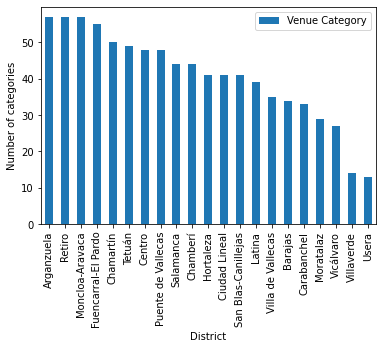

In [22]:
madrid_venues_group_category = (
    df_nearby_restaurants.groupby(['District','Venue Category'])
        .count().reset_index()[['District', 'Venue Category']]
            .groupby('District').count().reset_index()
)
# madrid_venues_group_category
ax = madrid_venues_group_category.sort_values(by="Venue Category", ascending=False).plot(x="District", y="Venue Category", kind="bar")
ax.set_ylabel("Number of categories")

#### 5. Top 10 venue categories for each district

In [23]:
# Create dummy dataframe
madrid_dummy_df = pd.get_dummies(df_nearby_restaurants[['Venue Category']], prefix="", prefix_sep="")

# Add District column back to dataframe
madrid_dummy_df['District'] = df_nearby_restaurants['District'] 

# Move District column to the first column
move_first_column = [madrid_dummy_df.columns[-1]] + list(madrid_dummy_df.columns[:-1])
madrid_dummy_df = madrid_dummy_df[move_first_column]

madrid_dummy_df.head()

,District,Accessories Store,Airport,Airport Lounge,Airport Service,American Restaurant,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Trail,Train Station,Travel Lounge,Turkish Restaurant,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Winery,Yoga Studio,Zoo
0,Centro,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Centro,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Centro,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Centro,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Centro,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 6. Group rows by district and by taking the mean of the frequency of occurrence of each category

In [24]:
madrid_means_df = madrid_dummy_df.groupby('District').mean().reset_index()
madrid_means_df.head()

,District,Accessories Store,Airport,Airport Lounge,Airport Service,American Restaurant,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Trail,Train Station,Travel Lounge,Turkish Restaurant,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Winery,Yoga Studio,Zoo
0,Arganzuela,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.0,0.0,0.020000,...,0.00,0.00,0.00,0.0,0.0,0.010000,0.00,0.00,0.0,0.0
1,Barajas,0.014925,0.014925,0.044776,0.074627,0.00,0.00,0.0,0.0,0.029851,...,0.00,0.00,0.00,0.0,0.0,0.014925,0.00,0.00,0.0,0.0
2,Carabanchel,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.0,0.0,0.000000,...,0.00,0.00,0.00,0.0,0.0,0.000000,0.00,0.00,0.0,0.0
3,Centro,0.000000,0.000000,0.000000,0.000000,0.00,0.01,0.0,0.0,0.000000,...,0.01,0.00,0.00,0.0,0.0,0.030000,0.01,0.01,0.0,0.0
4,Chamartín,0.000000,0.000000,0.000000,0.000000,0.01,0.00,0.0,0.0,0.000000,...,0.00,0.02,0.01,0.0,0.0,0.010000,0.00,0.00,0.0,0.0


#### 7. Show the 10 most common venues in each district.

In [25]:
def return_most_top_ten_common_venues(row, num_venues):
    categories = row.iloc[1:]
    categories_sorted = categories.sort_values(ascending=False)
    return categories_sorted.index.values[0:num_venues]

In [26]:
indicators = ['st', 'nd', 'rd']
num_top_ten_venues = 10

# Create columns according to number of top venues
columns = ['District']
for index in np.arange(num_top_ten_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(index+1, indicators[index]))
    except:
        columns.append('{}th Most Common Venue'.format(index+1))

# Create a new dataframe
madrid_venues_df = pd.DataFrame(columns=columns)
madrid_venues_df['District'] = madrid_means_df['District']

for index in np.arange(madrid_means_df.shape[0]):
    madrid_venues_df.iloc[index, 1:] = return_most_top_ten_common_venues(madrid_means_df.iloc[index, :], num_top_ten_venues)

madrid_venues_df.head(10)

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arganzuela,Spanish Restaurant,Restaurant,Park,Bakery,Art Gallery,Grocery Store,Gym,Burger Joint,Chinese Restaurant,Indie Theater
1,Barajas,Hotel,Spanish Restaurant,Airport Service,Duty-free Shop,Coffee Shop,Airport Lounge,Rental Car Location,Restaurant,Argentinian Restaurant,Snack Place
2,Carabanchel,Fast Food Restaurant,Restaurant,Tapas Restaurant,Grocery Store,Concert Hall,Spanish Restaurant,Bar,Pizza Place,Café,Plaza
3,Centro,Spanish Restaurant,Bar,Restaurant,Plaza,Bookstore,Mexican Restaurant,Brewery,Tapas Restaurant,Wine Bar,Hotel
4,Chamartín,Spanish Restaurant,Restaurant,Hotel,Bar,Gym / Fitness Center,Supermarket,Fast Food Restaurant,Café,Italian Restaurant,Breakfast Spot
5,Chamberí,Restaurant,Spanish Restaurant,Plaza,Tapas Restaurant,Japanese Restaurant,Italian Restaurant,Bar,Hotel,Coffee Shop,Bookstore
6,Ciudad Lineal,Spanish Restaurant,Restaurant,Bar,Supermarket,Tapas Restaurant,Café,Park,Hotel,Asian Restaurant,Coffee Shop
7,Fuencarral-El Pardo,Spanish Restaurant,Restaurant,Burger Joint,Coffee Shop,Pizza Place,Café,Italian Restaurant,Gym,Pharmacy,Japanese Restaurant
8,Hortaleza,Spanish Restaurant,Restaurant,Bar,Chinese Restaurant,Pizza Place,Gastropub,Supermarket,Bakery,Park,Hotel
9,Latina,Bar,Tapas Restaurant,Park,Restaurant,Italian Restaurant,Train Station,Pizza Place,Shopping Mall,Spanish Restaurant,Chinese Restaurant


### Cluster districts

#### 1. Run k-means to cluster the neighborhood into 3 clusters.

We want to cluster districts by the category "Restaurant" only. We will use the K-Means clustering to do this but first we need to determine how many k we need to use. The "elbow" method helps to find a good k.

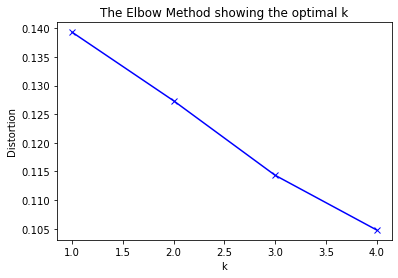

In [27]:
# Try with 5 different values of k to find the best one

# Set number of clusters
kmeans_clusters = 5

distortions = []

for k in range(1, kmeans_clusters):
    
    madrid_means_clustering_df = madrid_means_df.drop('District', 1)

    # Run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(madrid_means_clustering_df)

    # Find the distortion each k
    distortions.append(sum(np.min(cdist(madrid_means_clustering_df, kmeans.cluster_centers_, 'euclidean'), axis=1)) / madrid_means_clustering_df.shape[0])
    
    
plt.plot(range(1, kmeans_clusters), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Apparently the most suitable value for "elbow" is 3, therefore, I am going to use k=3.

#### 2. Filter only the data of the category "Restaurant"

In [28]:
madrid_grouped_restaurants = madrid_means_df[["District", "Restaurant"]]
madrid_grouped_restaurants

,District,Restaurant
0,Arganzuela,0.060000
1,Barajas,0.044776
2,Carabanchel,0.071429
3,Centro,0.060000
4,Chamartín,0.090000
5,Chamberí,0.110000
6,Ciudad Lineal,0.100000
7,Fuencarral-El Pardo,0.110000
8,Hortaleza,0.117021
9,Latina,0.051282


#### 3. Let's create a new dataframe look like madrid_grouped_restaurants but contains the cluster labels for each district.

In [29]:
df_restaurant_grouped_by_district = madrid_venues_df.copy()
df_restaurant_grouped_by_district["Cluster Labels"] = kmeans.labels_

# Add two columns Latitude and Logitude into cafe_merged
df_restaurant_grouped_by_district = df_restaurant_grouped_by_district.join(df_madrid.set_index("District"), on="District")

#Sort the table by cluster labels
df_restaurant_grouped_by_district.sort_values(["Cluster Labels"], inplace=True)

df_restaurant_grouped_by_district

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Population (1 Jan 2020),Area (ha),Density (pop/m2),Latitude,Longitude
10,Moncloa-Aravaca,Spanish Restaurant,Café,Tapas Restaurant,Hotel,Supermarket,Bar,Coffee Shop,Park,Restaurant,Ice Cream Shop,0,"122,164","4,653.11",0.263,40.435119,-3.718717
1,Barajas,Hotel,Spanish Restaurant,Airport Service,Duty-free Shop,Coffee Shop,Airport Lounge,Rental Car Location,Restaurant,Argentinian Restaurant,Snack Place,0,"50,158","4,192.28",0.120,40.474829,-3.577779
3,Centro,Spanish Restaurant,Bar,Restaurant,Plaza,Bookstore,Mexican Restaurant,Brewery,Tapas Restaurant,Wine Bar,Hotel,0,"140,991",522.82,2.697,43.542658,-5.664080
4,Chamartín,Spanish Restaurant,Restaurant,Hotel,Bar,Gym / Fitness Center,Supermarket,Fast Food Restaurant,Café,Italian Restaurant,Breakfast Spot,0,"148,039",917.55,1.613,40.476631,-3.675252
5,Chamberí,Restaurant,Spanish Restaurant,Plaza,Tapas Restaurant,Japanese Restaurant,Italian Restaurant,Bar,Hotel,Coffee Shop,Bookstore,0,"141,397",467.92,3.022,40.433140,-3.697201
6,Ciudad Lineal,Spanish Restaurant,Restaurant,Bar,Supermarket,Tapas Restaurant,Café,Park,Hotel,Asian Restaurant,Coffee Shop,0,"220,598","1,142.57",1.931,40.435851,-3.637071
7,Fuencarral-El Pardo,Spanish Restaurant,Restaurant,Burger Joint,Coffee Shop,Pizza Place,Café,Italian Restaurant,Gym,Pharmacy,Japanese Restaurant,0,"250,636","23,783.84",0.105,40.514767,-3.663639
8,Hortaleza,Spanish Restaurant,Restaurant,Bar,Chinese Restaurant,Pizza Place,Gastropub,Supermarket,Bakery,Park,Hotel,0,"193,833","2,741.98",0.707,40.462901,-3.656963
16,Tetuán,Spanish Restaurant,Restaurant,Seafood Restaurant,Bar,Hotel,Japanese Restaurant,Pub,Soccer Stadium,Tapas Restaurant,Ice Cream Shop,0,"161,991",537.47,3.014,40.460171,-3.700422
15,San Blas-Canillejas,Spanish Restaurant,Restaurant,Bar,Supermarket,Tapas Restaurant,Café,Park,Hotel,Asian Restaurant,Coffee Shop,0,"161,672","2,229.24",0.725,40.435851,-3.637071


#### 4. Create a new dataframe that includes the cluster as well as the top 10 venues for each district

In [30]:
# Add clustering labels
madrid_venues_df.insert(0, 'Cluster Labels', kmeans.labels_)

madrid_merged_df = df_madrid

# Merge madrid_venues_df with df_madrid to add latitude/longitude for each district
madrid_merged_df = madrid_merged_df.join(madrid_venues_df.set_index('District'), on='District')

madrid_merged_df.head()

,District,Population (1 Jan 2020),Area (ha),Density (pop/m2),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Centro,"140,991",522.82,2.697,43.542658,-5.664080,0,Spanish Restaurant,Bar,Restaurant,Plaza,Bookstore,Mexican Restaurant,Brewery,Tapas Restaurant,Wine Bar,Hotel
1,Arganzuela,"156,176",646.22,2.417,40.392827,-3.699313,1,Spanish Restaurant,Restaurant,Park,Bakery,Art Gallery,Grocery Store,Gym,Burger Joint,Chinese Restaurant,Indie Theater
2,Retiro,"120,873",546.62,2.211,40.402374,-3.677427,1,Spanish Restaurant,Hotel,Restaurant,Museum,Garden,Bakery,Park,Grocery Store,Gym,Italian Restaurant
3,Salamanca,"148,405",539.24,2.752,40.427325,-3.683587,0,Spanish Restaurant,Restaurant,Tapas Restaurant,Hotel,Boutique,Japanese Restaurant,Italian Restaurant,Jewelry Store,Clothing Store,Furniture / Home Store
4,Chamartín,"148,039",917.55,1.613,40.476631,-3.675252,0,Spanish Restaurant,Restaurant,Hotel,Bar,Gym / Fitness Center,Supermarket,Fast Food Restaurant,Café,Italian Restaurant,Breakfast Spot


#### 5. Create a map of Madrid based on each cluster in each district.

In [31]:
# Create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Set color scheme for the clusters
x = np.arange(kmeans_clusters)
ys = [i + x + (i*x)**2 for i in range(kmeans_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for latitude, longitude, neighborhood, cluster_index in zip(
        madrid_merged_df['Latitude'], 
        madrid_merged_df['Longitude'], 
        madrid_merged_df['District'], 
        madrid_merged_df['Cluster Labels']):
    label = folium.Popup(str(neighborhood) + ' Cluster ' + str(cluster_index), parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color=rainbow[cluster_index-1],
        fill=True,
        fill_color=rainbow[cluster_index-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

 ### Examine Clusters

Each cluster is examined where it can be distinguished based on each district of Madrid

#### Cluster 1

In [32]:
madrid_merged_df.loc[madrid_merged_df['Cluster Labels'] == 0, madrid_merged_df.columns[[1] + list(range(5, madrid_merged_df.shape[1]))]]

,Population (1 Jan 2020),Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"140,991",-5.664080,0,Spanish Restaurant,Bar,Restaurant,Plaza,Bookstore,Mexican Restaurant,Brewery,Tapas Restaurant,Wine Bar,Hotel
3,"148,405",-3.683587,0,Spanish Restaurant,Restaurant,Tapas Restaurant,Hotel,Boutique,Japanese Restaurant,Italian Restaurant,Jewelry Store,Clothing Store,Furniture / Home Store
4,"148,039",-3.675252,0,Spanish Restaurant,Restaurant,Hotel,Bar,Gym / Fitness Center,Supermarket,Fast Food Restaurant,Café,Italian Restaurant,Breakfast Spot
5,"161,991",-3.700422,0,Spanish Restaurant,Restaurant,Seafood Restaurant,Bar,Hotel,Japanese Restaurant,Pub,Soccer Stadium,Tapas Restaurant,Ice Cream Shop
6,"141,397",-3.697201,0,Restaurant,Spanish Restaurant,Plaza,Tapas Restaurant,Japanese Restaurant,Italian Restaurant,Bar,Hotel,Coffee Shop,Bookstore
7,"250,636",-3.663639,0,Spanish Restaurant,Restaurant,Burger Joint,Coffee Shop,Pizza Place,Café,Italian Restaurant,Gym,Pharmacy,Japanese Restaurant
8,"122,164",-3.718717,0,Spanish Restaurant,Café,Tapas Restaurant,Hotel,Supermarket,Bar,Coffee Shop,Park,Restaurant,Ice Cream Shop
14,"220,598",-3.637071,0,Spanish Restaurant,Restaurant,Bar,Supermarket,Tapas Restaurant,Café,Park,Hotel,Asian Restaurant,Coffee Shop
15,"193,833",-3.656963,0,Spanish Restaurant,Restaurant,Bar,Chinese Restaurant,Pizza Place,Gastropub,Supermarket,Bakery,Park,Hotel
19,"161,672",-3.637071,0,Spanish Restaurant,Restaurant,Bar,Supermarket,Tapas Restaurant,Café,Park,Hotel,Asian Restaurant,Coffee Shop


#### Cluster 2

In [33]:
madrid_merged_df.loc[madrid_merged_df['Cluster Labels'] == 1, madrid_merged_df.columns[[1] + list(range(5, madrid_merged_df.shape[1]))]]

,Population (1 Jan 2020),Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"156,176",-3.699313,1,Spanish Restaurant,Restaurant,Park,Bakery,Art Gallery,Grocery Store,Gym,Burger Joint,Chinese Restaurant,Indie Theater
2,"120,873",-3.677427,1,Spanish Restaurant,Hotel,Restaurant,Museum,Garden,Bakery,Park,Grocery Store,Gym,Italian Restaurant
9,"242,923",-3.764642,1,Bar,Tapas Restaurant,Park,Restaurant,Italian Restaurant,Train Station,Pizza Place,Shopping Mall,Spanish Restaurant,Chinese Restaurant
10,"261,118",-3.741459,1,Fast Food Restaurant,Restaurant,Tapas Restaurant,Grocery Store,Concert Hall,Spanish Restaurant,Bar,Pizza Place,Café,Plaza
12,"241,666",-3.666470,1,Spanish Restaurant,Restaurant,Pizza Place,Supermarket,Bar,Italian Restaurant,Grocery Store,Gym,Pub,Tapas Restaurant
13,"95,907",-3.636776,1,Pizza Place,Spanish Restaurant,Tapas Restaurant,Park,Grocery Store,Café,Plaza,Bar,Bakery,Gym / Fitness Center
17,"114,832",-3.621516,1,Grocery Store,Gym,Spanish Restaurant,Fast Food Restaurant,Restaurant,Supermarket,Bar,Bakery,Tapas Restaurant,Soccer Field
18,"74,235",-3.606052,1,Exhibit,Pizza Place,Grocery Store,Spanish Restaurant,Café,Tapas Restaurant,Park,Fast Food Restaurant,Gym / Fitness Center,Restaurant


#### Cluster 3

In [34]:
madrid_merged_df.loc[madrid_merged_df['Cluster Labels'] == 2, madrid_merged_df.columns[[1] + list(range(5, madrid_merged_df.shape[1]))]]

,Population (1 Jan 2020),Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,"143,365",-3.711469,2,Park,Fast Food Restaurant,Beer Garden,Accessories Store,Athletics & Sports,Pet Store,Café,Diner,Museum,Sporting Goods Shop


## Explore the center district

Analyzing the previous data, it has been decided to put the business in the central district of Madrid, since every day many people pass through the center and that can give greater profitability to the business in front of it if we locate it in another district in Madrid.

#### 1. Get example of first items response API Foursquare

In [35]:
items = response["groups"][0]["items"]
print("Number of items: %i" % len(items))
items[0]

Number of items: 50


{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '4adcda37f964a5201f3c21e3',
  'name': 'Puerta del Sol',
  'location': {'address': 'Pl. Puerta del Sol',
   'lat': 40.41679436967101,
   'lng': -3.703562021255493,
   'labeledLatLngs': [{'label': 'display',
     'lat': 40.41679436967101,
     'lng': -3.703562021255493}],
   'postalCode': '28013',
   'cc': 'ES',
   'city': 'Madrid',
   'state': 'Madrid',
   'country': 'España',
   'formattedAddress': ['Pl. Puerta del Sol',
    '28013 Madrid Madrid',
    'España']},
  'categories': [{'id': '4bf58dd8d48988d164941735',
    'name': 'Plaza',
    'pluralName': 'Plazas',
    'shortName': 'Plaza',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/plaza_',
     'suffix': '.png'},
    'primary': True}],
  'photos': {'count': 0, 'groups': []}},
 'referralId': 'e-0-4adcda37f964a5201f3c21e3-0'}

#### 2. Explore the restaurants of urbant districts

Looking at the data previously treated, it is decided to look for the restaurant's site in the central district of Madrid, so here in this step you will look for the nearby restaurants in the central district.

In [36]:
df_restaurants = []
for item in items:
    venue = item["venue"]
    categories, uid, name, location = venue["categories"], venue["id"], venue["name"], venue["location"]

    shortname = categories[0]["shortName"]
    address =  ''
    
    if hasattr(location, 'address'):
      address = location['address']
    if not "postalCode" in location:
        continue
        
    postalcode = location["postalCode"]
    lat = location["lat"]
    lng = location["lng"]
    
    data_restaurant_row = (uid, name, shortname, address, postalcode, lat, lng)
    df_restaurants.append(data_restaurant_row)
    
df_nearby_restaurants = pd.DataFrame(df_restaurants, columns=["UID", "Name", "Shortname", "Address", "Postal Code", "Latitude", "Longitude"])

print("\n")
print("Found %i restaurants" % len(df_nearby_restaurants))
df_nearby_restaurants.head()



Found 47 restaurants


,UID,Name,Shortname,Address,Postal Code,Latitude,Longitude
0,4adcda37f964a5201f3c21e3,Puerta del Sol,Plaza,,28013,40.416794,-3.703562
1,4f33cbace4b0b5f6dee6d145,La Pulpería de Victoria,Seafood,,28012,40.416506,-3.701709
2,57442b9e498eb4d238e3bece,InClan Brutal Bar,Tapas,,28012,40.415023,-3.701864
3,4bddaac30ee3a59370242eb0,Club del Gourmet Corte Ingles,Gourmet,,28013,40.417497,-3.704686
4,538a4c78498e264f18c776b2,Apple Puerta del Sol,Electronics,,28013,40.416900,-3.702251


In the next step, we will execute a very important part: obtain the coordinates of Madrid city and create a folio map that will help to visualize what we obtained from the data.

In [37]:
madrid_map = folium.Map(location=[latitude, longitude], zoom_start=14)

def add_markers(df):
    for (i, row) in df.iterrows():
        label = folium.Popup(row["Name"], parse_html=True)
        folium.CircleMarker(
            [row["Latitude"], row["Longitude"]],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.5,
            parse_html=False).add_to(madrid_map)

add_markers(df_nearby_restaurants)
madrid_data = df_nearby_restaurants[["Latitude", "Longitude"]].to_numpy().tolist()
madrid_map.add_child(plugins.HeatMap(madrid_data))

madrid_map

Here we can see where we are going to choose our business on the map compared to the other restaurants.

In [38]:
latitude_restaurant = 40.415761
longitude_restaurant = -3.704823
madrid_map = folium.Map(location=[latitude_restaurant, longitude_restaurant], zoom_start=14)
add_markers(df_nearby_restaurants)
folium.CircleMarker(
    [latitude_restaurant, longitude_restaurant],
    radius=15,
    popup="Casa Ribeira",
    color='green',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(madrid_map)
madrid_map